# Warsztaty badawcze - Projekt 2

## Real Estate Price Analysis - Random Forest

### Wiktoria Boguszewska, Mateusz Zacharecki, Patrycja Żak

In [1]:
!pip install scikit-optimize

In [2]:
!pip install transformers

In [3]:
!pip install torch==2.3.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from skopt import BayesSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error
import random

from transformers import BertTokenizer, BertModel
import torch

import warnings
warnings.filterwarnings('ignore')

random.seed(42)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### Wczytanie danych

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
df = pd.read_csv("real_estate_imputed.csv")
df.head()

,district_lon,district_lat,no_rooms,m,price_per_m,map_lon,map_lat,building_floors_num,created_at_first_ts,created_at_ts,media_types_internet,media_types_cable-television,media_types_phone,equipment_types_furniture,equipment_types_tv,equipment_types_stove,equipment_types_washing_machine,equipment_types_dishwasher,equipment_types_oven,equipment_types_fridge,extras_types_balcony,extras_types_air_conditioning,extras_types_lift,extras_types_garage,extras_types_basement,extras_types_separate_kitchen,extras_types_two_storey,extras_types_garden,extras_types_terrace,extras_types_usable_room,security_types_roller_shutters,security_types_monitoring,security_types_closed_area,security_types_alarm,security_types_entryphone,security_types_anti_burglary_door,building_material_breezeblock,building_material_brick,building_material_cellular_concrete,building_material_concrete,building_material_concrete_plate,building_material_hydroton,building_material_other,building_material_reinforced_concrete,building_material_silikat,windows_type_aluminium,windows_type_plastic,windows_type_wooden,heating_boiler_room,heating_electrical,heating_gas,heating_other,heating_tiled_stove,heating_urban,construction_status_ready_to_use,construction_status_to_completion,construction_status_to_renovation,building_ownership_co_operative_ownership,building_ownership_co_operative_ownership_with_a_land_and_mortgage_registe,building_ownership_full_ownership,building_ownership_share,building_type_apartment,building_type_block,building_type_house,building_type_ribbon,building_type_tenement,title,description,building_type,floor_no,building_material,windows_type,heating,build_year,construction_status,rent,building_ownership,remote_services,floor_no_numeric,free_from_year,free_from,media_types,security_types,equipment_types,extras_types,created_at_first,created_at
0,16.9408,52.38356,3.0,48.000000,6020.83,16.959516,52.391494,4.0,1.515071e+09,1.515411e+09,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Przestronne mieszkanie na Ratajach,<p>Zapraszam do zapoznania się z ofertą sprzed...,block,floor_1,concrete_plate,plastic,urban,1980,ready_to_use,500.0,co_operative_ownership_with_a_land_and_mortgag...,0,1.0,2019.0,NaN,"['cable-television', 'internet', 'phone']",[''],[''],"['balcony', 'separate_kitchen']",2018-01-04 13:11:05,2018-01-08 11:27:35
1,16.9408,52.38356,3.0,61.000000,6213.11,16.950743,52.380535,4.0,1.516044e+09,1.516879e+09,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Przestronne mieszkanie na Ratajach,<p>Zapraszam do zapoznania się z ofertą sprzed...,block,ground_floor,concrete_plate,wooden,urban,1980,ready_to_use,550.0,co_operative_ownership_with_a_land_and_mortgag...,0,0.0,2019.0,NaN,"['cable-television', 'internet']",[''],[''],['balcony'],2018-01-15 19:12:07,2018-01-25 11:11:31
2,16.9408,52.38356,3.0,63.000000,5380.95,16.945860,52.393188,4.0,1.515074e+09,1.515650e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Rataje Nowe Miasto Niski Blok,<p>Weychan Nieruchomości Monika Hałas - Kurcza...,block,floor_3,concrete_plate,plastic,urban,1980,ready_to_use,500.0,co_operative_ownership,0,3.0,2019.0,NaN,[''],['entryphone'],[''],"['balcony', 'basement']",2018-01-04 13:53:29,2018-01-11 05:55:12
3,16.9408,52.38356,3.0,59.200001,5574.32,16.980279,52.391129,4.0,1.515755e+09,1.517323e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0

### Feature selection and standarization

In [7]:
df.shape

(5953, 87)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5953 entries, 0 to 5952
Data columns (total 87 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   district_lon                                                                5953 non-null   float64
 1   district_lat                                                                5953 non-null   float64
 2   no_rooms                                                                    5953 non-null   float64
 3   m                                                                           5953 non-null   float64
 4   price_per_m                                                                 5953 non-null   float64
 5   map_lon                                                                     5953 non-null   float64
 6   map_lat                                         

In [9]:
pd.set_option('display.max_columns', None)

Do modelu bazowego usuwamy kolumny, które nie będziemy używać, tj. opis, długość i szerokość geogrfaiczna

In [10]:
df1 = pd.read_csv("real_estate_imputed.csv")
df.head()

,district_lon,district_lat,no_rooms,m,price_per_m,map_lon,map_lat,building_floors_num,created_at_first_ts,created_at_ts,media_types_internet,media_types_cable-television,media_types_phone,equipment_types_furniture,equipment_types_tv,equipment_types_stove,equipment_types_washing_machine,equipment_types_dishwasher,equipment_types_oven,equipment_types_fridge,extras_types_balcony,extras_types_air_conditioning,extras_types_lift,extras_types_garage,extras_types_basement,extras_types_separate_kitchen,extras_types_two_storey,extras_types_garden,extras_types_terrace,extras_types_usable_room,security_types_roller_shutters,security_types_monitoring,security_types_closed_area,security_types_alarm,security_types_entryphone,security_types_anti_burglary_door,building_material_breezeblock,building_material_brick,building_material_cellular_concrete,building_material_concrete,building_material_concrete_plate,building_material_hydroton,building_material_other,building_material_reinforced_concrete,building_material_silikat,windows_type_aluminium,windows_type_plastic,windows_type_wooden,heating_boiler_room,heating_electrical,heating_gas,heating_other,heating_tiled_stove,heating_urban,construction_status_ready_to_use,construction_status_to_completion,construction_status_to_renovation,building_ownership_co_operative_ownership,building_ownership_co_operative_ownership_with_a_land_and_mortgage_registe,building_ownership_full_ownership,building_ownership_share,building_type_apartment,building_type_block,building_type_house,building_type_ribbon,building_type_tenement,title,description,building_type,floor_no,building_material,windows_type,heating,build_year,construction_status,rent,building_ownership,remote_services,floor_no_numeric,free_from_year,free_from,media_types,security_types,equipment_types,extras_types,created_at_first,created_at
0,16.9408,52.38356,3.0,48.000000,6020.83,16.959516,52.391494,4.0,1.515071e+09,1.515411e+09,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Przestronne mieszkanie na Ratajach,<p>Zapraszam do zapoznania się z ofertą sprzed...,block,floor_1,concrete_plate,plastic,urban,1980,ready_to_use,500.0,co_operative_ownership_with_a_land_and_mortgag...,0,1.0,2019.0,NaN,"['cable-television', 'internet', 'phone']",[''],[''],"['balcony', 'separate_kitchen']",2018-01-04 13:11:05,2018-01-08 11:27:35
1,16.9408,52.38356,3.0,61.000000,6213.11,16.950743,52.380535,4.0,1.516044e+09,1.516879e+09,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Przestronne mieszkanie na Ratajach,<p>Zapraszam do zapoznania się z ofertą sprzed...,block,ground_floor,concrete_plate,wooden,urban,1980,ready_to_use,550.0,co_operative_ownership_with_a_land_and_mortgag...,0,0.0,2019.0,NaN,"['cable-television', 'internet']",[''],[''],['balcony'],2018-01-15 19:12:07,2018-01-25 11:11:31
2,16.9408,52.38356,3.0,63.000000,5380.95,16.945860,52.393188,4.0,1.515074e+09,1.515650e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Rataje Nowe Miasto Niski Blok,<p>Weychan Nieruchomości Monika Hałas - Kurcza...,block,floor_3,concrete_plate,plastic,urban,1980,ready_to_use,500.0,co_operative_ownership,0,3.0,2019.0,NaN,[''],['entryphone'],[''],"['balcony', 'basement']",2018-01-04 13:53:29,2018-01-11 05:55:12
3,16.9408,52.38356,3.0,59.200001,5574.32,16.980279,52.391129,4.0,1.515755e+09,1.517323e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5953 entries, 0 to 5952
Data columns (total 87 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   district_lon                                                                5953 non-null   float64
 1   district_lat                                                                5953 non-null   float64
 2   no_rooms                                                                    5953 non-null   float64
 3   m                                                                           5953 non-null   float64
 4   price_per_m                                                                 5953 non-null   float64
 5   map_lon                                                                     5953 non-null   float64
 6   map_lat                                         

In [12]:
df.drop(['title', 'description', 'map_lon', 'map_lat'], axis=1, inplace=True)
# Zostawiamy wstępnie daty i szerokość, długość geo. dzielnic

In [13]:
df.head()

,district_lon,district_lat,no_rooms,m,price_per_m,building_floors_num,created_at_first_ts,created_at_ts,media_types_internet,media_types_cable-television,media_types_phone,equipment_types_furniture,equipment_types_tv,equipment_types_stove,equipment_types_washing_machine,equipment_types_dishwasher,equipment_types_oven,equipment_types_fridge,extras_types_balcony,extras_types_air_conditioning,extras_types_lift,extras_types_garage,extras_types_basement,extras_types_separate_kitchen,extras_types_two_storey,extras_types_garden,extras_types_terrace,extras_types_usable_room,security_types_roller_shutters,security_types_monitoring,security_types_closed_area,security_types_alarm,security_types_entryphone,security_types_anti_burglary_door,building_material_breezeblock,building_material_brick,building_material_cellular_concrete,building_material_concrete,building_material_concrete_plate,building_material_hydroton,building_material_other,building_material_reinforced_concrete,building_material_silikat,windows_type_aluminium,windows_type_plastic,windows_type_wooden,heating_boiler_room,heating_electrical,heating_gas,heating_other,heating_tiled_stove,heating_urban,construction_status_ready_to_use,construction_status_to_completion,construction_status_to_renovation,building_ownership_co_operative_ownership,building_ownership_co_operative_ownership_with_a_land_and_mortgage_registe,building_ownership_full_ownership,building_ownership_share,building_type_apartment,building_type_block,building_type_house,building_type_ribbon,building_type_tenement,building_type,floor_no,building_material,windows_type,heating,build_year,construction_status,rent,building_ownership,remote_services,floor_no_numeric,free_from_year,free_from,media_types,security_types,equipment_types,extras_types,created_at_first,created_at
0,16.9408,52.38356,3.0,48.000000,6020.83,4.0,1.515071e+09,1.515411e+09,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,block,floor_1,concrete_plate,plastic,urban,1980,ready_to_use,500.0,co_operative_ownership_with_a_land_and_mortgag...,0,1.0,2019.0,NaN,"['cable-television', 'internet', 'phone']",[''],[''],"['balcony', 'separate_kitchen']",2018-01-04 13:11:05,2018-01-08 11:27:35
1,16.9408,52.38356,3.0,61.000000,6213.11,4.0,1.516044e+09,1.516879e+09,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,block,ground_floor,concrete_plate,wooden,urban,1980,ready_to_use,550.0,co_operative_ownership_with_a_land_and_mortgag...,0,0.0,2019.0,NaN,"['cable-television', 'internet']",[''],[''],['balcony'],2018-01-15 19:12:07,2018-01-25 11:11:31
2,16.9408,52.38356,3.0,63.000000,5380.95,4.0,1.515074e+09,1.515650e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,block,floor_3,concrete_plate,plastic,urban,1980,ready_to_use,500.0,co_operative_ownership,0,3.0,2019.0,NaN,[''],['entryphone'],[''],"['balcony', 'basement']",2018-01-04 13:53:29,2018-01-11 05:55:12
3,16.9408,52.38356,3.0,59.200001,5574.32,4.0,1.515755e+09,1.517323e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,block,floor_1,concrete_plate,wooden,urban,1980,ready_to_use,500.0,co_operative_ownership,0,1.0,2019.0,NaN,[''],['entryphone'],[''],"['balcony', 'basement']",2018-01-12 11:10:57,2018-01-30 14:38:39
4,16.9408,52.38356,2.0,38.000000,6815.79,10.0,1.514893e+09,1.516285e+09,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.

In [14]:
# Propozycja do budowania modelu regresji liniowej:
# Zmieniamy daty na timestamp, który i tak potem będziemy standaryzowac, więc usuwamy datetime

In [15]:
df.drop(['created_at_first', 'created_at'], axis=1, inplace=True)

In [16]:
df.head()

,district_lon,district_lat,no_rooms,m,price_per_m,building_floors_num,created_at_first_ts,created_at_ts,media_types_internet,media_types_cable-television,media_types_phone,equipment_types_furniture,equipment_types_tv,equipment_types_stove,equipment_types_washing_machine,equipment_types_dishwasher,equipment_types_oven,equipment_types_fridge,extras_types_balcony,extras_types_air_conditioning,extras_types_lift,extras_types_garage,extras_types_basement,extras_types_separate_kitchen,extras_types_two_storey,extras_types_garden,extras_types_terrace,extras_types_usable_room,security_types_roller_shutters,security_types_monitoring,security_types_closed_area,security_types_alarm,security_types_entryphone,security_types_anti_burglary_door,building_material_breezeblock,building_material_brick,building_material_cellular_concrete,building_material_concrete,building_material_concrete_plate,building_material_hydroton,building_material_other,building_material_reinforced_concrete,building_material_silikat,windows_type_aluminium,windows_type_plastic,windows_type_wooden,heating_boiler_room,heating_electrical,heating_gas,heating_other,heating_tiled_stove,heating_urban,construction_status_ready_to_use,construction_status_to_completion,construction_status_to_renovation,building_ownership_co_operative_ownership,building_ownership_co_operative_ownership_with_a_land_and_mortgage_registe,building_ownership_full_ownership,building_ownership_share,building_type_apartment,building_type_block,building_type_house,building_type_ribbon,building_type_tenement,building_type,floor_no,building_material,windows_type,heating,build_year,construction_status,rent,building_ownership,remote_services,floor_no_numeric,free_from_year,free_from,media_types,security_types,equipment_types,extras_types
0,16.9408,52.38356,3.0,48.000000,6020.83,4.0,1.515071e+09,1.515411e+09,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,block,floor_1,concrete_plate,plastic,urban,1980,ready_to_use,500.0,co_operative_ownership_with_a_land_and_mortgag...,0,1.0,2019.0,NaN,"['cable-television', 'internet', 'phone']",[''],[''],"['balcony', 'separate_kitchen']"
1,16.9408,52.38356,3.0,61.000000,6213.11,4.0,1.516044e+09,1.516879e+09,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,block,ground_floor,concrete_plate,wooden,urban,1980,ready_to_use,550.0,co_operative_ownership_with_a_land_and_mortgag...,0,0.0,2019.0,NaN,"['cable-television', 'internet']",[''],[''],['balcony']
2,16.9408,52.38356,3.0,63.000000,5380.95,4.0,1.515074e+09,1.515650e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,block,floor_3,concrete_plate,plastic,urban,1980,ready_to_use,500.0,co_operative_ownership,0,3.0,2019.0,NaN,[''],['entryphone'],[''],"['balcony', 'basement']"
3,16.9408,52.38356,3.0,59.200001,5574.32,4.0,1.515755e+09,1.517323e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,block,floor_1,concrete_plate,wooden,urban,1980,ready_to_use,500.0,co_operative_ownership,0,1.0,2019.0,NaN,[''],['entryphone'],[''],"['balcony', 'basement']"
4,16.9408,52.38356,2.0,38.000000,6815.79,10.0,1.514893e+09,1.516285e+09,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,block,floo

In [17]:
# Do modelu bazowego nie użyjemy tych tekstowych kolumn

In [18]:
df.drop(['media_types', 'equipment_types', 'extras_types', 'security_types', 'building_material', 'windows_type', 
         'heating', 'construction_status', 'building_ownership', 'building_type'], axis=1, inplace=True)

In [19]:
#kolumny tekstowe

text_columns = df.select_dtypes(include=['object']).columns.tolist()
print(text_columns)

['floor_no', 'free_from']


In [20]:
df[text_columns]

,floor_no,free_from
0,floor_1,NaN
1,ground_floor,NaN
2,floor_3,NaN
3,floor_1,NaN
4,floor_1,NaN
...,...,...
5948,floor_3,NaN
5949,floor_3,NaN
5950,floor_6,NaN
5951,floor_4,NaN


In [21]:
df.drop('floor_no', axis=1, inplace=True)

In [22]:
df.drop(['free_from', 'free_from_year'], axis=1, inplace=True) # 80% braków danych

In [23]:
new_text_columns = df.select_dtypes(include=['object']).columns.tolist()

In [24]:
new_text_columns

[]

In [25]:
X, y = df.loc[:, df.columns != "price_per_m"], df["price_per_m"]

## Random Forest

In [26]:
# Do lepszego podziału stworzymy koszyki do stratyfikacji danych

In [27]:
y.shape

(5953,)

In [28]:
y_binned = pd.qcut(y, q=10, duplicates='drop')

In [29]:
print(y_binned)

0       (5853.66, 6234.38]
1       (5853.66, 6234.38]
2       (525.089, 5384.62]
3       (5384.62, 5853.66]
4       (6560.69, 6903.85]
               ...        
5948     (7272.73, 7700.0]
5949     (8750.0, 20000.0]
5950     (7272.73, 7700.0]
5951     (7272.73, 7700.0]
5952    (6903.85, 7272.73]
Name: price_per_m, Length: 5953, dtype: category
Categories (10, interval[float64, right]): [(525.089, 5384.62] < (5384.62, 5853.66] < (5853.66, 6234.38] < (6234.38, 6560.69] ... (7272.73, 7700.0] < (7700.0, 8116.28] < (8116.28, 8750.0] < (8750.0, 20000.0]]


In [30]:
def find_optimal_bins(X, y, max_bins=10, test_size=0.2, random_state=42):
    best_q = 1
    best_diff = float('inf')
    
    for q in range(2, max_bins + 1):
        y_binned = pd.qcut(y, q=q, duplicates='drop')  # tworzymy koszyki
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y_binned
        )
        # Sprawdzamy różnicę między średnimi
        diff = abs(y_train.mean() - y_test.mean())
        
        # Zapisujemy najlepszą liczbę koszyków, gdzie różnica jest najmniejsza
        if diff < best_diff:
            best_diff = diff
            best_q = q
    
    return best_q

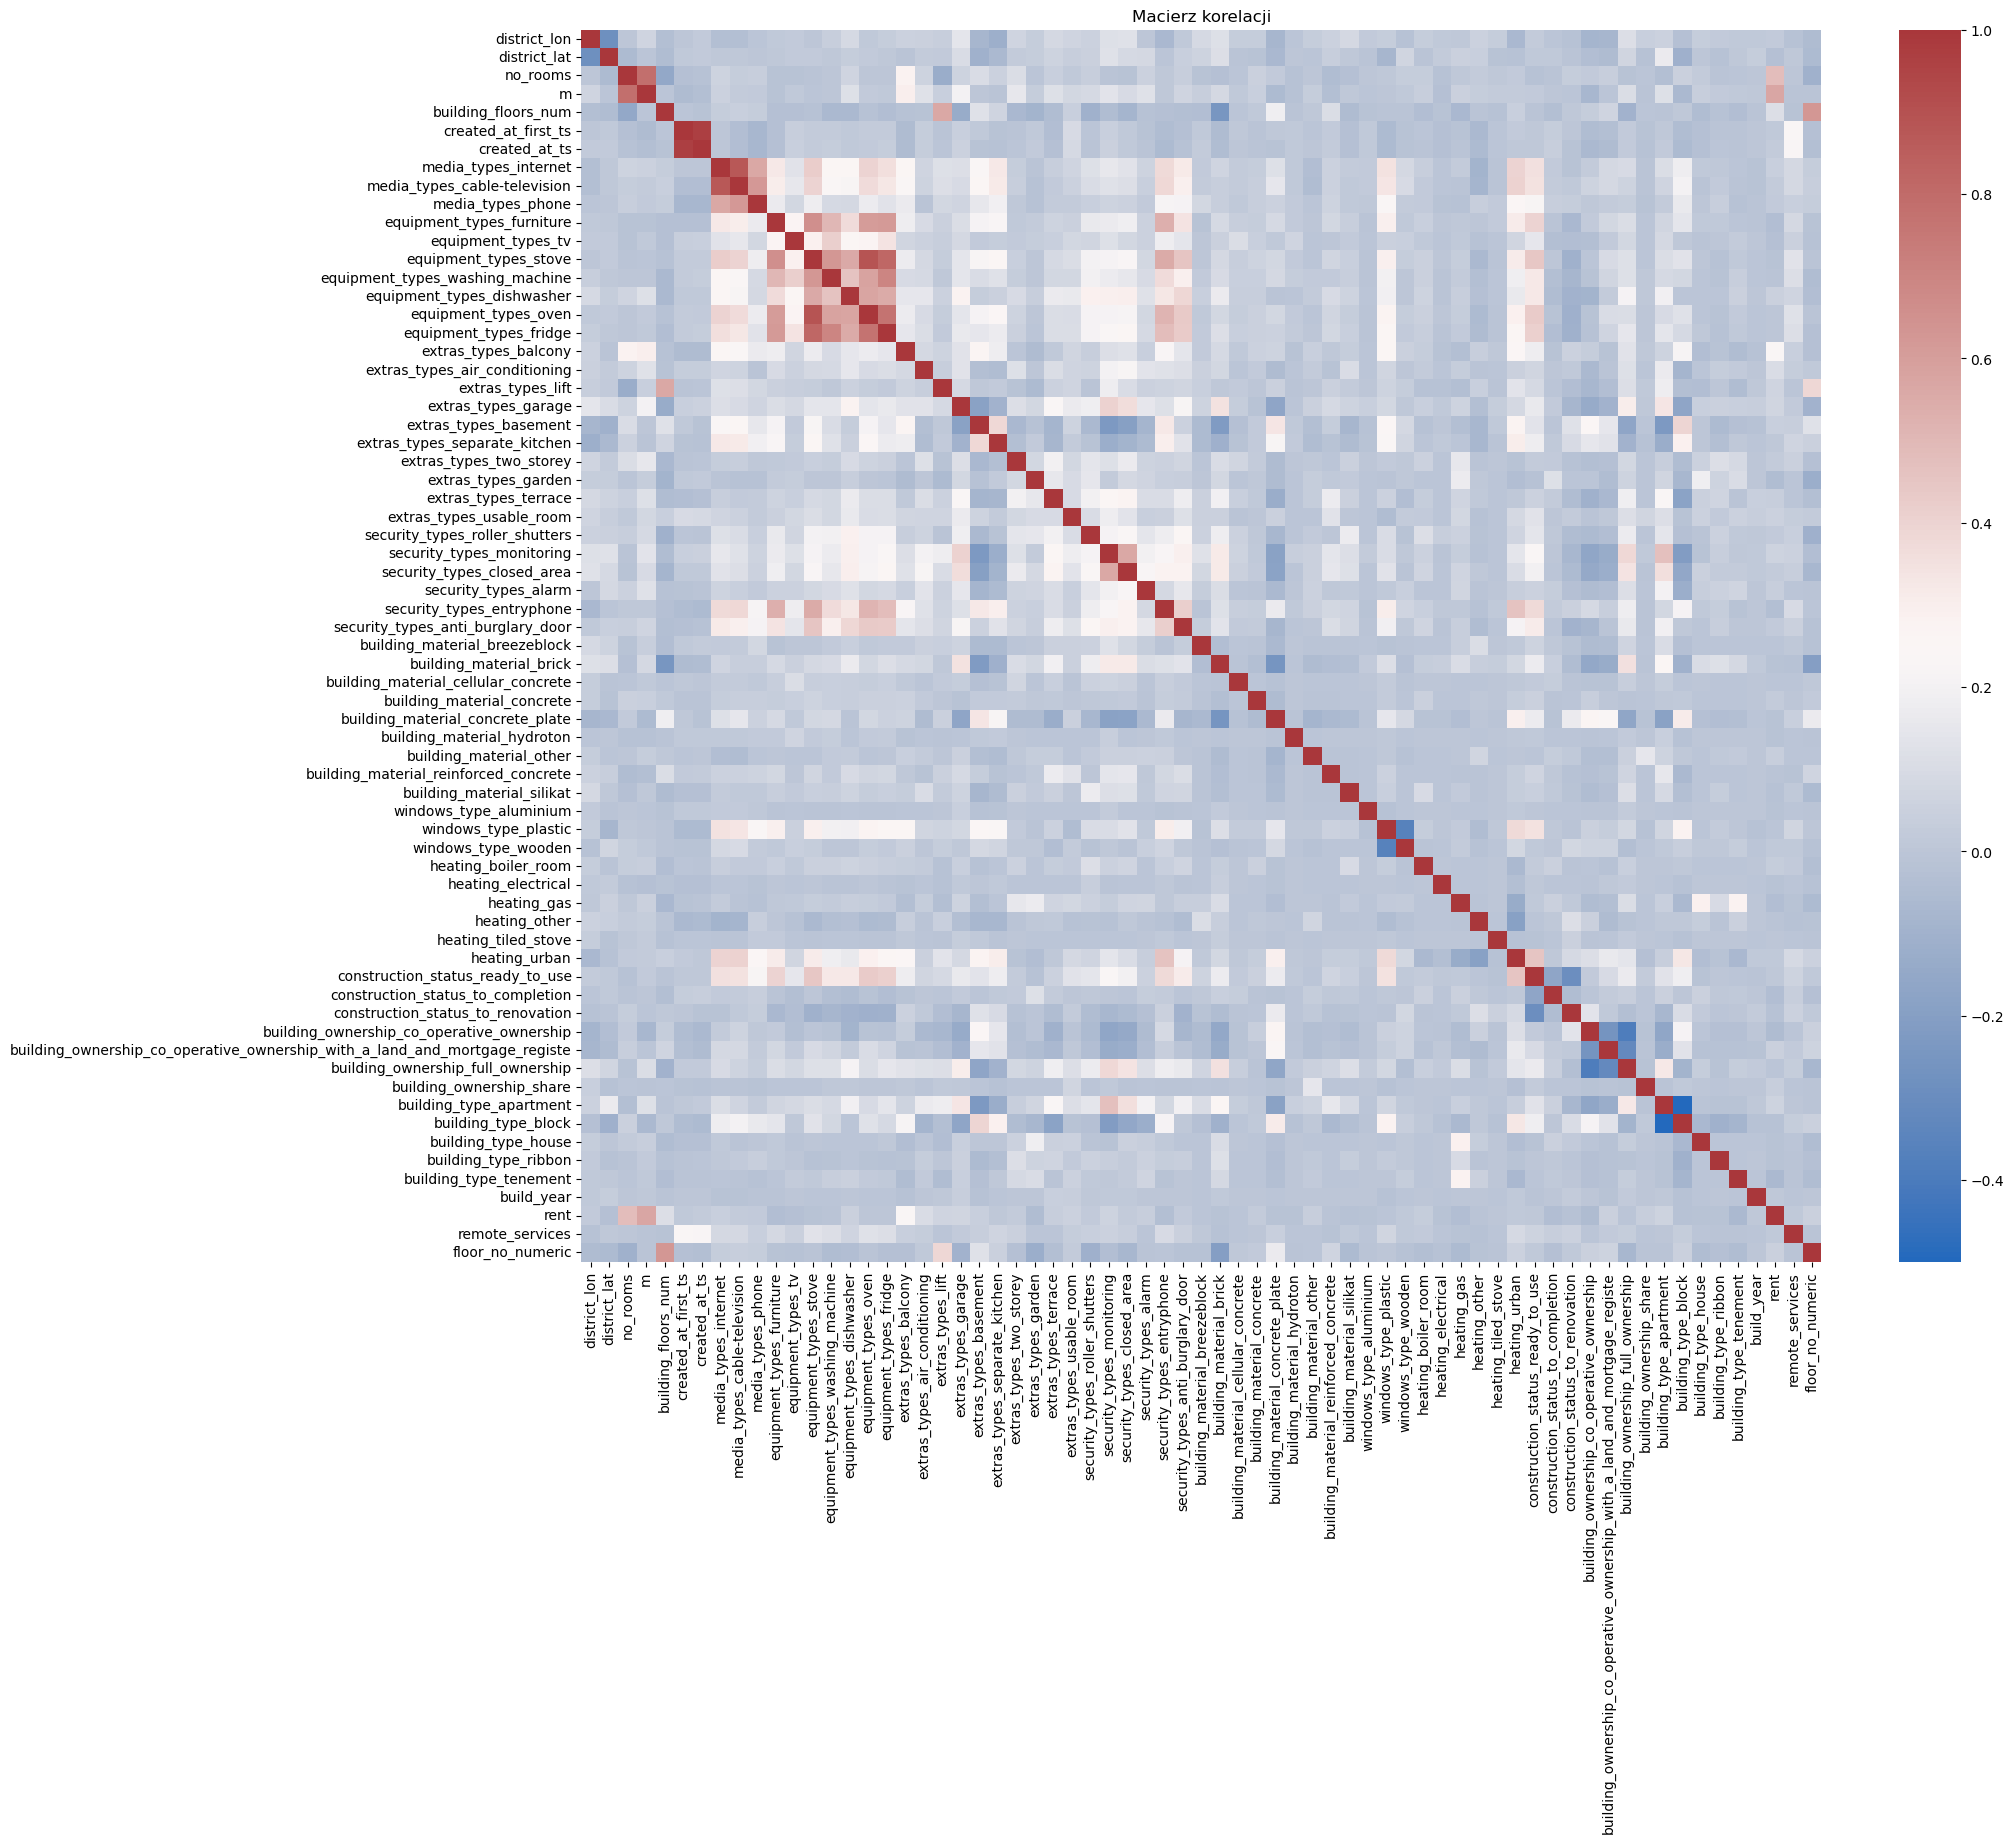

In [31]:
plt.figure(figsize = (20,16))
sns.heatmap(X.corr(), annot=False, cmap='vlag')
plt.title("Macierz korelacji")
plt.show()

In [32]:
c = X.iloc[:,:-1].corr().abs()

#tylko dolna część macierzy
mask = np.triu(np.ones(c.shape), k=1).astype(bool)
s = c.where(mask).unstack()

result = s[np.abs(s) >= 0.7].sort_values(ascending=False)
print(result.to_string())

created_at_ts                 created_at_first_ts      0.969027
equipment_types_oven          equipment_types_stove    0.888789
media_types_cable-television  media_types_internet     0.876749
equipment_types_fridge        equipment_types_stove    0.814722
m                             no_rooms                 0.789163
equipment_types_fridge        equipment_types_oven     0.770328


In [33]:
columns_to_drop = ['created_at_ts',
                   'equipment_types_stove',
                   'media_types_internet'] # corr > 0.8

In [34]:
X_rf = X.drop(columns_to_drop, axis=1)

In [35]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y, test_size=0.2, random_state=42)

In [36]:
print(y_test_rf.mean())
print(y_train_rf.mean())

7017.856120906801
7021.039886602268


In [37]:
optimal_bins_rf = find_optimal_bins(X_rf, y, max_bins=20)
print(optimal_bins_rf)

15


In [38]:
y_binned_rf = pd.qcut(y, q=optimal_bins_rf, duplicates='drop')

In [39]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y, test_size=0.2, random_state=42, stratify=y_binned_rf)

In [40]:
abs(y_train_rf.mean() - y_test_rf.mean())

1.9064393351918625

In [41]:
# RF nie jest dobry dla zbyt dużej ilości zmiennych

In [42]:
selector = SelectKBest(score_func=mutual_info_regression, k=30)
X_train_selected = selector.fit_transform(X_train_rf, y_train_rf)
X_test_selected = selector.transform(X_test_rf)

# Przestrzeń przeszukiwania dla hiperparametrów RandomForest
param_grid = {
    'n_estimators': (50, 300),               # Liczba drzew
    'max_depth': (5, 50),                    # Maksymalna głębokość drzewa
    'min_samples_split': (2, 10),            # Minimalna liczba próbek do podziału
    'min_samples_leaf': (1, 10),             # Minimalna liczba próbek na liść
    'max_features': (0.1, 1.0, 'uniform')    # Proporcja cech używanych przy każdym podziale
}

# Konfiguracja BayesSearchCV
bayes_search_rf = BayesSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    search_spaces=param_grid,
    n_iter=10,              # Liczba iteracji przeszukiwania
    cv=3,                   # 5-krotna walidacja krzyżowa
    random_state=42,
    n_jobs=-1               # Wykorzystanie wszystkich rdzeni procesora
)

# Dopasowanie BayesSearchCV do danych treningowych z wyselekcjonowanymi cechami
bayes_search_rf.fit(X_train_selected, y_train_rf)

# Pobranie najlepszego modelu i optymalnych hiperparametrów
best_rf = bayes_search_rf.best_estimator_
best_params = bayes_search_rf.best_params_
print("Najlepsze hiperparametry:", best_params)

# Predykcja na zbiorze testowym za pomocą najlepszego modelu
y_pred = best_rf.predict(X_test_selected)

# Obliczenie RMSE
rmse = np.sqrt(mean_squared_error(y_test_rf, y_pred))
print(f'RMSE: {rmse}')

Najlepsze hiperparametry: OrderedDict([('max_depth', 38), ('max_features', 0.9454327638424945), ('min_samples_leaf', 2), ('min_samples_split', 4), ('n_estimators', 250)])
RMSE: 730.7490533150999


## Model Random Forest z danymi tekstowymi

#### TF-IDF

In [45]:
df1 = pd.read_csv("real_estate_imputed.csv")

# Przygotowanie danych tekstowych
df1['description'] = df1['description'].fillna('')
df1['title'] = df1['title'].fillna('')
df1['full_text'] = df1['title'] + ' ' + df1['description']

# Przekształcenie tekstu na TF-IDF tylko dla wybranych próbek
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
X_text_all = tfidf.fit_transform(df1['full_text']).toarray()

df_tfidf = np.hstack([X_rf, X_text_all])

X_train, X_test, y_train, y_test = train_test_split(
            df_tfidf, y, test_size=0.2, random_state=42, stratify=y_binned)

selector = SelectKBest(score_func=mutual_info_regression, k=30)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Model RandomForest z optymalnymi hiperparametrami
optimized_rf_model = RandomForestRegressor(
    n_estimators=250,
    max_depth=38,
    max_features=0.945,
    min_samples_leaf=2,
    min_samples_split=4,
    random_state=42
)
optimized_rf_model.fit(X_train_selected, y_train)

# Predykcja i ocena modelu
y_pred_combined = optimized_rf_model.predict(X_test_selected)
rmse_combined = mean_squared_error(y_test, y_pred_combined, squared=False)
print(f'RMSE dla modelu z cechami tekstowymi i wybranymi cechami liczbowymi: {rmse_combined}')

RMSE dla modelu z cechami tekstowymi i wybranymi cechami liczbowymi: 815.8335560705722


In [46]:
df1 = pd.read_csv("real_estate_imputed.csv")

# Przygotowanie danych tekstowych
df1['description'] = df1['description'].fillna('')
df1['title'] = df1['title'].fillna('')
df1['full_text'] = df1['title'] + ' ' + df1['description']

# Przekształcenie tekstu na TF-IDF tylko dla wybranych próbek
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
X_text_all = tfidf.fit_transform(df1['full_text']).toarray()

In [47]:
df_tfidf = np.hstack([X_rf, X_text_all])

X_train, X_test, y_train, y_test = train_test_split(
            df_tfidf, y, test_size=0.2, random_state=42, stratify=y_binned)

selector = SelectKBest(score_func=mutual_info_regression, k=30)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Przestrzeń przeszukiwania dla hiperparametrów RandomForest
param_grid = {
    'n_estimators': (50, 300),               # Liczba drzew
    'max_depth': (5, 50),                    # Maksymalna głębokość drzewa
    'min_samples_split': (2, 10),            # Minimalna liczba próbek do podziału
    'min_samples_leaf': (1, 10),             # Minimalna liczba próbek na liść
    'max_features': (0.1, 1.0, 'uniform')    # Proporcja cech używanych przy każdym podziale
}

# Konfiguracja BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    search_spaces=param_grid,
    n_iter=10,              # Liczba iteracji przeszukiwania
    cv=3,                   # 5-krotna walidacja krzyżowa
    random_state=42,
    n_jobs=-1               # Wykorzystanie wszystkich rdzeni procesora
)

# Dopasowanie BayesSearchCV do danych treningowych z wyselekcjonowanymi cechami
bayes_search.fit(X_train_selected, y_train)

# Pobranie najlepszego modelu i optymalnych hiperparametrów
best = bayes_search.best_estimator_
best_params = bayes_search.best_params_
print("Najlepsze hiperparametry:", best_params)

# Predykcja na zbiorze testowym za pomocą najlepszego modelu
y_pred = best.predict(X_test_selected)

# Obliczenie RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

Najlepsze hiperparametry: OrderedDict([('max_depth', 38), ('max_features', 0.9454327638424945), ('min_samples_leaf', 2), ('min_samples_split', 4), ('n_estimators', 250)])
RMSE: 820.994542200922


#### Bert

In [48]:
df2 = pd.read_csv("real_estate_imputed.csv")

# Wczytanie modelu BERT i tokenizera
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    return embedding

title_embeddings = np.array([get_bert_embedding(title) for title in df2['title']])
description_embeddings = np.array([get_bert_embedding(description) for description in df2['description']])

In [49]:
textual_embeddings = np.hstack([title_embeddings, description_embeddings])
df_embedded = np.hstack([X_rf, textual_embeddings])

X_train, X_test, y_train, y_test = train_test_split(
            df_embedded, y, test_size=0.2, random_state=42, stratify=y_binned)

selector = SelectKBest(score_func=mutual_info_regression, k=30)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Przestrzeń przeszukiwania dla hiperparametrów RandomForest
param_grid = {
    'n_estimators': (50, 300),               # Liczba drzew
    'max_depth': (5, 50),                    # Maksymalna głębokość drzewa
    'min_samples_split': (2, 10),            # Minimalna liczba próbek do podziału
    'min_samples_leaf': (1, 10),             # Minimalna liczba próbek na liść
    'max_features': (0.1, 1.0, 'uniform')    # Proporcja cech używanych przy każdym podziale
}

# Konfiguracja BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    search_spaces=param_grid,
    n_iter=10,              # Liczba iteracji przeszukiwania
    cv=3,                   # 5-krotna walidacja krzyżowa
    random_state=42,
    n_jobs=-1               # Wykorzystanie wszystkich rdzeni procesora
)

# Dopasowanie BayesSearchCV do danych treningowych z wyselekcjonowanymi cechami
bayes_search.fit(X_train_selected, y_train)

# Pobranie najlepszego modelu i optymalnych hiperparametrów
best = bayes_search.best_estimator_
best_params = bayes_search.best_params_
print("Najlepsze hiperparametry:", best_params)

# Predykcja na zbiorze testowym za pomocą najlepszego modelu
y_pred = best.predict(X_test_selected)

# Obliczenie RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

Najlepsze hiperparametry: OrderedDict([('max_depth', 38), ('max_features', 0.9454327638424945), ('min_samples_leaf', 2), ('min_samples_split', 4), ('n_estimators', 250)])
RMSE: 987.7287358334514


## Model z uwzględnieniem cech geograficznych

In [55]:
df3 = pd.read_csv("real_estate_imputed_geopy.csv")

df_geo = np.hstack([X_rf, df3[['distance_to_park', 'distance_to_school', 'distance_to_bus_stop', 'distance_to_market', 'distance_to_shopping_center']]])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
            df_geo, y, test_size=0.2, random_state=42, stratify=y_binned)

selector = SelectKBest(score_func=mutual_info_regression, k=30)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Przestrzeń przeszukiwania dla hiperparametrów RandomForest
param_grid = {
    'n_estimators': (50, 300),               # Liczba drzew
    'max_depth': (5, 50),                    # Maksymalna głębokość drzewa
    'min_samples_split': (2, 10),            # Minimalna liczba próbek do podziału
    'min_samples_leaf': (1, 10),             # Minimalna liczba próbek na liść
    'max_features': (0.1, 1.0, 'uniform')    # Proporcja cech używanych przy każdym podziale
}

# Konfiguracja BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    search_spaces=param_grid,
    n_iter=10,              # Liczba iteracji przeszukiwania
    cv=3,                   # 5-krotna walidacja krzyżowa
    random_state=42,
    n_jobs=-1               # Wykorzystanie wszystkich rdzeni procesora
)

# Dopasowanie BayesSearchCV do danych treningowych z wyselekcjonowanymi cechami
bayes_search.fit(X_train_selected, y_train)

# Pobranie najlepszego modelu i optymalnych hiperparametrów
best = bayes_search.best_estimator_
best_params = bayes_search.best_params_
print("Najlepsze hiperparametry:", best_params)

# Predykcja na zbiorze testowym za pomocą najlepszego modelu
y_pred = best.predict(X_test_selected)

# Obliczenie RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

Najlepsze hiperparametry: OrderedDict([('max_depth', 38), ('max_features', 0.9454327638424945), ('min_samples_leaf', 2), ('min_samples_split', 4), ('n_estimators', 250)])
RMSE: 829.9592162789367


## Finalny model Random Forest

In [58]:
df_final = np.hstack([X_rf, X_text_all, df3[['distance_to_park', 'distance_to_school', 'distance_to_bus_stop', 'distance_to_market', 'distance_to_shopping_center']]])

X_train, X_test, y_train, y_test = train_test_split(
            df_final, y, test_size=0.2, random_state=42, stratify=y_binned)

selector = SelectKBest(score_func=mutual_info_regression, k=30)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Przestrzeń przeszukiwania dla hiperparametrów RandomForest
param_grid = {
    'n_estimators': (50, 300),               # Liczba drzew
    'max_depth': (5, 50),                    # Maksymalna głębokość drzewa
    'min_samples_split': (2, 10),            # Minimalna liczba próbek do podziału
    'min_samples_leaf': (1, 10),             # Minimalna liczba próbek na liść
    'max_features': (0.1, 1.0, 'uniform')    # Proporcja cech używanych przy każdym podziale
}

# Konfiguracja BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    search_spaces=param_grid,
    n_iter=10,              # Liczba iteracji przeszukiwania
    cv=3,                   # 5-krotna walidacja krzyżowa
    random_state=42,
    n_jobs=-1               # Wykorzystanie wszystkich rdzeni procesora
)

# Dopasowanie BayesSearchCV do danych treningowych z wyselekcjonowanymi cechami
bayes_search.fit(X_train_selected, y_train)

# Pobranie najlepszego modelu i optymalnych hiperparametrów
best = bayes_search.best_estimator_
best_params = bayes_search.best_params_
print("Najlepsze hiperparametry:", best_params)

# Predykcja na zbiorze testowym za pomocą najlepszego modelu
y_pred = best.predict(X_test_selected)

# Obliczenie RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

Najlepsze hiperparametry: OrderedDict([('max_depth', 38), ('max_features', 0.9454327638424945), ('min_samples_leaf', 2), ('min_samples_split', 4), ('n_estimators', 250)])
RMSE: 824.5220442119581
